In [4]:
import os
import numpy as np
from pyplr import utils
import pandas as pd
from classPLRfromGitHub import PLR
from pyplr import graphing
from pyplr import preproc
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import simpledialog
import sys
import importlib
import checkdataPLR
#from preprocessing import ProcessConfig

In [5]:
# Define the subject_id
subject_id = 'PJ25_1_PLR3'

# Load the CSV file
if os.getlogin()=='marco':
    rec_dir = f"/home/marco/Nextcloud/KatharinaBeispieldaten/{subject_id[:4]}/{subject_id}/"
else:
    rec_dir = f"/Users/Katharina/Desktop/Beispieldaten/{subject_id[:4]}/{subject_id}/"

utils.print_file_structure(rec_dir)

#data_dir="/Users/Katharina/Desktop/Beispieldaten"
#rec_dir="/Users/Katharina/Desktop/Beispieldaten"
# Load the data from the pupil player
# Pupil Labs recording directory
# Load the CSV file
#rec_dir="/Users/Katharina/Desktop/Beispieldaten/PJ01/PJ01_1_PLR1.csv"
#rec_dir="/Users/Katharina/Desktop/Testi/pyplr_analysis/TestiFile.csv"
#rec_dir = f"/Users/Katharina/Desktop/Beispieldaten/{subject_id[:4]}/{subject_id}/"
#rec_dir = "/Users/Katharina/Desktop/Beispieldaten/PJ23/PJ23_2_PLR1/exports/000/pupil_positions.csv"
#utils.print_file_structure(rec_dir)

/
    annotation_timestamps.npy
exports/
    000/
        annotations.csv
        export_info.csv
        gaze_positions.csv
        pupil_gaze_positions_info.txt
        pupil_positions.csv
pyplr_analysis/


In [6]:
# define the patient ID for the dataframe and assign the 4 light strenghts
Light_strenght_1 = 1
Light_strenght_2 = 2
Light_strenght_3 = 3
Light_strenght_4 = 4



# Sampling frequency
SAMPLE_RATE = 120

# Columns to load
use_cols = ['confidence',
            'method',
            'pupil_timestamp',
            'eye_id',
            'diameter']

pupil_cols = ['diameter']

# Check if the pyplr_analysis directory exists
if not os.path.exists(os.path.join(rec_dir, 'pyplr_analysis')):
    # Create the directory if it doesn't exist
    os.makedirs(os.path.join(rec_dir, 'pyplr_analysis'))

# Get a handle on a subject
s = utils.new_subject(
    rec_dir, export='000', out_dir_nm='pyplr_analysis')

************************************************************
*****************************  *****************************
************************************************************


In [7]:
# Load pupil data, method has to be changed to '3d' otherwise multiple repeat error
#eye_id=best takes the eye with the best confidence, eye_id=0 takes right, 1 takes left
samples = utils.load_pupil(
    s['data_dir'], eye_id='left', method='2d', cols=use_cols)
samples

# load the pupil data for the current combination of eye_id and method
samples = utils.load_pupil(s['data_dir'], eye_id='left', method='2d', cols=use_cols)


Loaded 12796 samples
Loaded 12796 samples


Loaded 4 events


,index,label,duration
timestamp,,,
35878.388867,776,LIGHT_ON,NaN
35893.600913,1230,LIGHT_ON,NaN
35908.816838,1684,LIGHT_ON,NaN
35923.996789,2137,LIGHT_ON,NaN


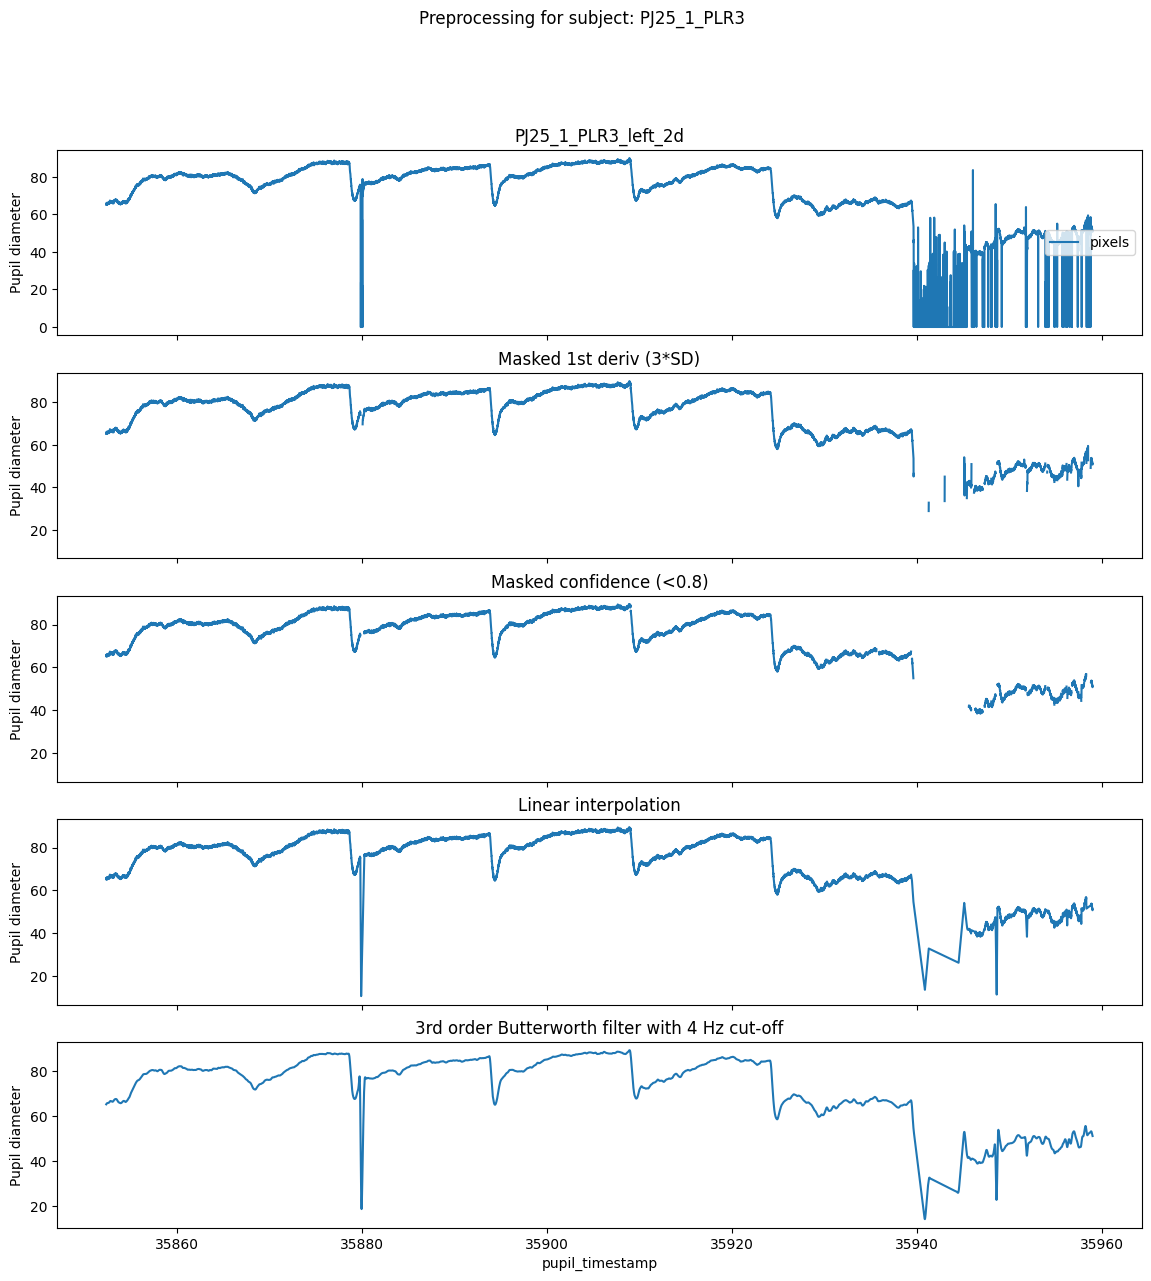

In [8]:
# Make figure for processing, append figure to pupil_preprocessing
f, axs = graphing.pupil_preprocessing_figure(nrows=5, subject=f"{subject_id}" )
# Plot the raw data
# Plot the raw data
samples[pupil_cols].plot(title=f"{subject_id}_left_2d", ax=axs[0], legend=True)
axs[0].legend(loc='center right', labels=['pixels'])
# Mask first derivative
#Default is a threshold of 3 SD from the mean first derivate
# If there are a lot of blinks the mean first derivate is higher
# Therefore set the threshold lower 
samples = preproc.mask_pupil_first_derivative(
    samples, threshold=3.0, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

# Mask confidence
samples = preproc.mask_pupil_confidence(
    samples, threshold=0.8, mask_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Masked confidence (<0.8)', ax=axs[2], legend=False)
 

# Interpolate
samples = preproc.interpolate_pupil(
    samples, interp_cols=pupil_cols)
samples[pupil_cols].plot(
    title='Linear interpolation', ax=axs[3], legend=False)

# Smooth
samples = preproc.butterworth_series(
    samples, fields=pupil_cols, filt_order=3,
    cutoff_freq=4/(SAMPLE_RATE/2))
samples[pupil_cols].plot(
    title='3rd order Butterworth filter with 4 Hz cut-off',
    ax=axs[4], legend=False);

events = utils.load_annotations(s['data_dir'])
events


In [9]:
# Number of samples to extract and which sample
# should mark the onset of the event
# 120 data points equal one second with a sample rate of 120 
# Real duration is Duration-ONSET_IDX, example 240 equals 1 second
#ONSET_IDX is the time before light stimulus that gets sampled 
DURATION = 1200
ONSET_IDX = 120

# Extract the event ranges, gets range of total duration (720) and shifts the onset_idx to the left in time, therefore 120 is the 0 point
ranges = utils.extract(
    samples,
    events,
    offset=-ONSET_IDX,
    duration=DURATION,
    borrow_attributes=['color'])

# Convert data to numeric format
ranges = ranges.apply(pd.to_numeric, errors='coerce')

# Calculate baselines, the time before the onset is 0 to 120
baselines = ranges.loc[:, range(0, ONSET_IDX), :].groupby(level=0, axis=1).mean()

# New columns for percent signal change, simply adds 2 new columns with percent change
ranges = preproc.percent_signal_change(
    ranges, baselines, pupil_cols)
ranges

print(ranges.loc[0:3])

ranges1 = ranges.loc[0]
ranges2 = ranges.loc[1]
ranges3 = ranges.loc[2]
ranges4 = ranges.loc[3]

print(ranges4)


Extracted ranges for 4 events
             eye_id  confidence   diameter  method  interpolated   
event onset                                                        
0     0           1    1.000000  87.239516     NaN             0  \
      1           1    0.916905  87.236503     NaN             0   
      2           1    0.965555  87.237430     NaN             0   
      3           1    1.000000  87.242349     NaN             0   
      4           1    0.980751  87.251141     NaN             0   
...             ...         ...        ...     ...           ...   
3     1195        1    1.000000  66.200889     NaN             0   
      1196        1    1.000000  66.221759     NaN             0   
      1197        1    0.947483  66.245772     NaN             0   
      1198        1    0.910884  66.273188     NaN             0   
      1199        1    0.914298  66.304183     NaN             0   

                 orig_idx  color  diameter_pc  
event onset                          

,value
Baseline,84.066170
Latency_a,0.216667
Latency_b,0.233333
T2MaxVel,0.358333
T2MaxCon,0.908333
T2Rec75pc,0.000000
PeakCon,58.524538
ConAmplitude,25.541633
VelConMax,65.364853
VelConAve,36.248256


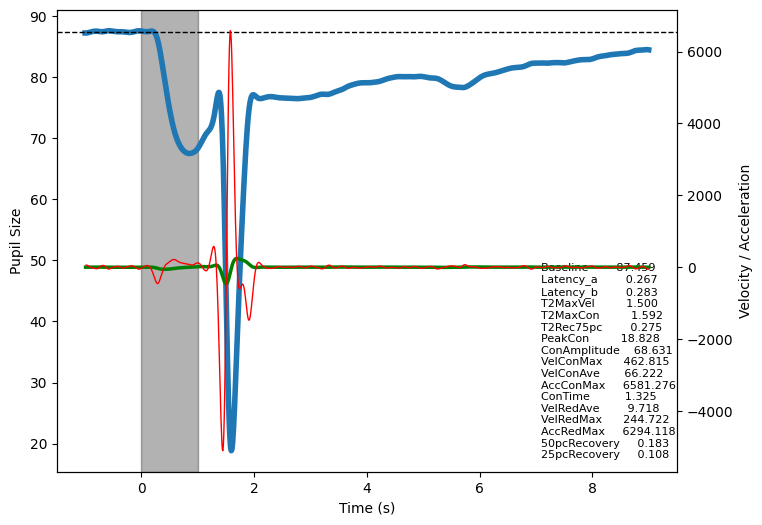

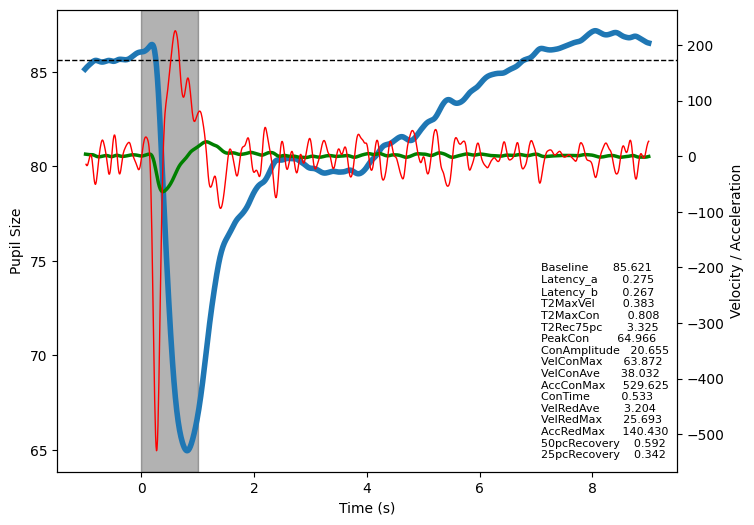

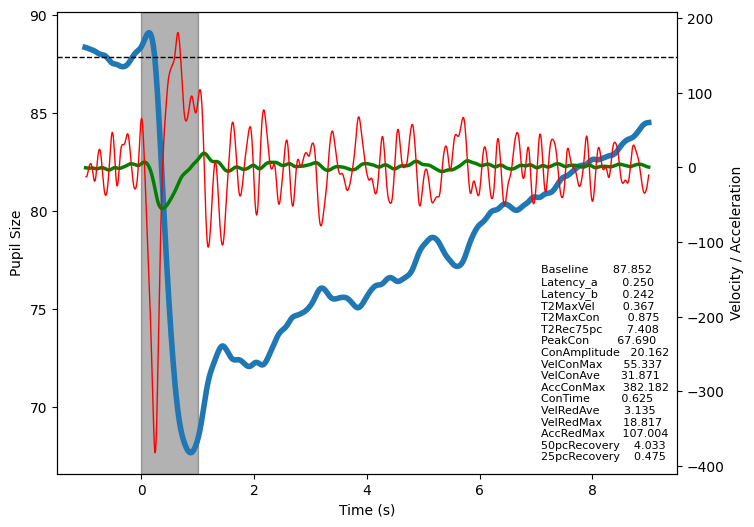

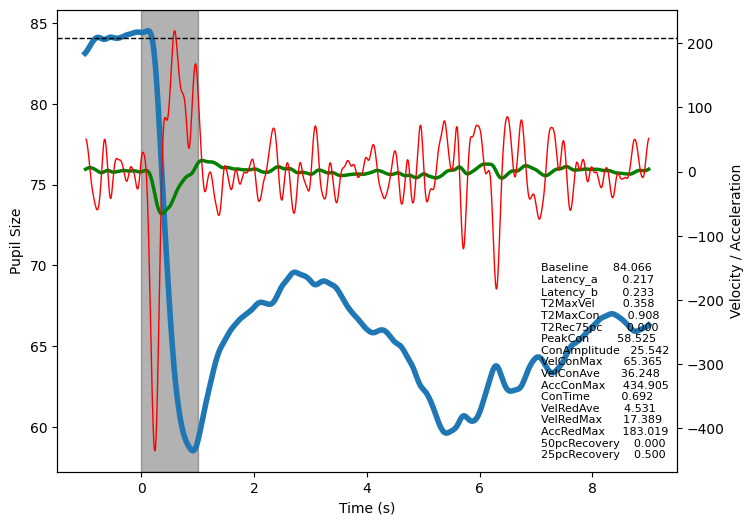

In [10]:
def get_average_plr(input_range):
    average_plr = input_range.groupby(level=0)['diameter'].mean().to_numpy()
    return PLR(average_plr,
              sample_rate=SAMPLE_RATE,
              onset_idx=ONSET_IDX,
              stim_duration=1)

plr1 = get_average_plr(ranges1)
plr2 = get_average_plr(ranges2)
plr3 = get_average_plr(ranges3)
plr4 = get_average_plr(ranges4)

plr_all = [plr1, plr2, plr3, plr4]


#plot graphs for vel = velocity in green, acc = acceleration in red and parameters
fig1 = plr1.plot(vel=True, acc=True, print_params=True)
fig2 = plr2.plot(vel=True, acc=True, print_params=True)
fig3 = plr3.plot(vel=True, acc=True, print_params=True)
fig4 = plr4.plot(vel=True, acc=True, print_params=True)

params1 = plr1.parameters()
params1

params2 = plr2.parameters()
params2

params3 = plr3.parameters()
params3

params4 = plr4.parameters()
params4



In [11]:
def get_pyplr_results(plr):
#D1 = baseline pupilsize, in mm
    D1 = plr.baseline()
    print("D1: ",D1)
    
    #D2 = minimum pupilsize, in mm 
    D2 = plr.peak_constriction()
    print("D2: ",D2)
    
    #AMP = constriction amplitude, in mm
    AMP = D1-D2
    print("AMP: ",AMP)
    
    #VCmax = maximum velocity of constriction, in mm/s
    VCmax = plr.max_constriction_velocity()
    print("VCmax: ",VCmax)
    
    #ACmax = maximum acceleration, in mm/s ?
    ACmax = plr.max_constriction_acceleration()
    print("ACmax: ",ACmax)
    
    #T1 = latency from the onset of the light stimulus to the maximum acceleration
    # in milliseconds - looks like in seconds on the graph  
    T1 = plr.latency_to_constriction_b()
    print("T1: ",T1)
    
    #T2 = time to maximum velocity, looks like in seconds on the graph 
    T2 = plr.time_to_max_velocity()
    print("T2: ",T2)
    
    #T3 = time to maximum constriction, in milliseconds - looks like in seconds on graph 
    T3 = plr.time_to_max_constriction()
    print("T3: ",T3)
    
    #relative constriction amplitude: AMP/D1
    rel_AMP = AMP/D1
    print("rel_AMP: ", rel_AMP)
    
    #time to 75% redilation 
    redil_75 = plr.time_to_75pc_recovery()
    print("redil_75", redil_75)
    
    #time to 50% redilation
    redil_50 = plr.time_to_50pc_recovery()
    print('redil_50', redil_50)
    
    redil_25 = plr.time_to_25pc_recovery()
    print('redil_25', redil_25)
    
    # create a CSV file
    return {
            'D1':D1,
            'D2': D2,
            'AMP': AMP,
            'VCmax':VCmax,
            'ACmax': ACmax,
            'T1': T1,
            'T2':T2,
            'T3':T3,
            "rel_AMP": rel_AMP,
            "redil_75": redil_75,
            'redil_50': redil_50,
            'redil_25': redil_25
            }

pyplr_results = {'Subject ID': [subject_id, subject_id, subject_id, subject_id],
                 'D1':[],
                 'D2':[],
                 'AMP': [],
                 'VCmax':[],
                 'ACmax': [],
                 'T1': [],
                 'T2':[],
                 'T3':[],
                 "rel_AMP": [],
                 "redil_75": [],
                 'redil_50': [],
                 'redil_25': [],
                 'Light_strenght': [Light_strenght_1, Light_strenght_2, Light_strenght_3, Light_strenght_4]}


In [12]:
plr_all = [plr1, plr2, plr3, plr4]

for plr in plr_all:
    pyplr_result = get_pyplr_results(plr)
    pyplr_results["D1"].append(pyplr_result["D1"])
    pyplr_results["D2"].append(pyplr_result["D2"])
    pyplr_results["AMP"].append(pyplr_result["AMP"])
    pyplr_results["VCmax"].append(pyplr_result["VCmax"])
    pyplr_results["ACmax"].append(pyplr_result["ACmax"])
    pyplr_results["T1"].append(pyplr_result["T1"])
    pyplr_results["T2"].append(pyplr_result["T2"])
    pyplr_results["T3"].append(pyplr_result["T3"])
    pyplr_results["rel_AMP"].append(pyplr_result["rel_AMP"])
    pyplr_results["redil_75"].append(pyplr_result["redil_75"])
    pyplr_results["redil_50"].append(pyplr_result["redil_50"])
    pyplr_results["redil_25"].append(pyplr_result["redil_25"])




D1:  87.45903602022669
D2:  18.828473319787566
AMP:  68.63056270043913
VCmax:  462.81548871653
ACmax:  6581.276122765519
T1:  0.2833333333333333
T2:  1.5
T3:  1.5916666666666666
rel_AMP:  0.7847166607755305
redil_75 0.275
redil_50 0.18333333333333332
redil_25 0.10833333333333334
D1:  85.62141968728284
D2:  64.96618485707104
AMP:  20.655234830211796
VCmax:  63.87198965121854
ACmax:  529.6247160051053
T1:  0.26666666666666666
T2:  0.3833333333333333
T3:  0.8083333333333333
rel_AMP:  0.2412391070558209
redil_75 3.3249999999999997
redil_50 0.5916666666666667
redil_25 0.3416666666666667
D1:  87.8518972232685
D2:  67.69000230529353
AMP:  20.161894917974962
VCmax:  55.33684013880645
ACmax:  382.18238200804535
T1:  0.24166666666666667
T2:  0.36666666666666664
T3:  0.875
rel_AMP:  0.22949868534694404
redil_75 7.408333333333333
redil_50 4.033333333333333
redil_25 0.475
D1:  84.06617032040872
D2:  58.52453768356884
AMP:  25.54163263683988
VCmax:  65.36485304514713
ACmax:  434.90542109116177
T1:  

In [13]:
df = pd.DataFrame(pyplr_results)
df["eye_id"] = "1"
df["method"] = "2d"


#always change the directory to what the sample gets saved 
df.to_csv(f"/Users/Katharina/Desktop/Beispieldaten/{subject_id[:4]}/{subject_id}/pyplr_analysis/PLR_left_2d_results.csv", index=False)

print(df)


    Subject ID         D1         D2        AMP       VCmax        ACmax   
0  PJ25_1_PLR3  87.459036  18.828473  68.630563  462.815489  6581.276123  \
1  PJ25_1_PLR3  85.621420  64.966185  20.655235   63.871990   529.624716   
2  PJ25_1_PLR3  87.851897  67.690002  20.161895   55.336840   382.182382   
3  PJ25_1_PLR3  84.066170  58.524538  25.541633   65.364853   434.905421   

         T1        T2        T3   rel_AMP  redil_75  redil_50  redil_25   
0  0.283333  1.500000  1.591667  0.784717  0.275000  0.183333  0.108333  \
1  0.266667  0.383333  0.808333  0.241239  3.325000  0.591667  0.341667   
2  0.241667  0.366667  0.875000  0.229499  7.408333  4.033333  0.475000   
3  0.233333  0.358333  0.908333  0.303828  0.000000  0.000000  0.500000   

   Light_strenght eye_id method  
0               1      1     2d  
1               2      1     2d  
2               3      1     2d  
3               4      1     2d  
